In [38]:
# %%writefile merge/heuristics.py
import os
import cv2 as cv
import matplotlib.pyplot as plt
import json
import numpy as np
import torch

Overwriting merge/heuristics.py


In [33]:
from dataset.dataset import ImageDataset
from modules.split_modules import SplitModel
from merge.heuristics import *

SCITSR_PATH = '/Users/longhoang/Developer/table-reg/data/scitsr-split-train'
CHUNK_JSON_LABEL = '/Users/longhoang/Developer/table-reg/data/SciTSR/train/label/chunk_label.json'
MODEL_WEIGHT = '/Users/longhoang/Developer/table-reg/pretrain-models/split-merge/split_v2.pth'

In [2]:
# Helper functions
def view_imgs(imgs, titles=None):
    fig = plt.figure(figsize=(7, 7))
    for i, img in enumerate(imgs):
        plt.subplot(1, len(imgs), i + 1)
        if titles is not None:
            plt.title(titles[i])
        if img.ndim == 3:
            if img.shape[-1] == 3:
                plt.imshow(img)
            else:
                plt.imshow(img[..., 0], cmap='gray', vmin=0, vmax=255)
        else:
            plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    plt.show()

def load_image(img_path):
    img = cv.imread(img_path)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    return img

def path2name(img_path):
    return os.path.splitext(os.path.basename(img_path))[0]

In [3]:
# LOAD MODEL
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = SplitModel(3)
net = torch.nn.DataParallel(net).to(device)

if device == 'cuda':
    net.load_state_dict(torch.load(MODEL_WEIGHT))
else:
    net.load_state_dict(torch.load(MODEL_WEIGHT, map_location=torch.device('cpu')))

device

'cpu'

In [6]:
# LOAD DATA AND GROUND TRUTH
scitsr_subset = os.path.join(SCITSR_PATH, 'train')
# scitsr_val = os.path.join(SCITSR_PATH, 'val')
img_dir = os.path.join(scitsr_subset, 'img')

imgs_paths = [os.path.join(img_dir, p) for p in os.listdir(img_dir)]
print(f'Loaded {len(imgs_paths)} images')

with open(CHUNK_JSON_LABEL, 'r') as f:
    chunk_labels = json.load(f)
print(f'Loaded {len(chunk_labels)} chunk labels (text bounding boxes)')

merge_label_path = os.path.join(scitsr_subset, 'label', 'merge_label.json')
with open(merge_label_path, 'r') as f:
    merge_labels = json.load(f)
print(f'Loaded {len(merge_labels)} merge labels')

split_label_path = os.path.join(scitsr_subset, 'label', 'split_label.json')
with open(split_label_path, 'r') as f:
    split_labels = json.load(f)
dataset = ImageDataset(img_dir, split_labels, 8, scale=1, returns_image_name=True)
print(f'Loaded dataset with {len(dataset)} examples')

Loaded 10000 images
Loaded 11971 chunk labels (text bounding boxes)
Loaded 10000 merge labels
Loaded dataset with 10000 examples


In [88]:
# %%writefile -a merge/heuristics.py

def torch2numpy(img:torch.tensor, r:torch.tensor, c:torch.tensor):
    '''
    Args:
        img -- torch tensor of shape (C, H, W)
        r -- torch tensor of shape (1, H)
        c -- torch tensor of shape (1, W)
    '''
    img = (img * 255).numpy().transpose(1,2,0).astype(np.uint8)
    r = r[-1]>0.5
    c = c[-1]>0.5
    c = c.cpu().detach().numpy().astype(np.uint8)
    r = r.cpu().detach().numpy().astype(np.uint8)
    return img, r, c

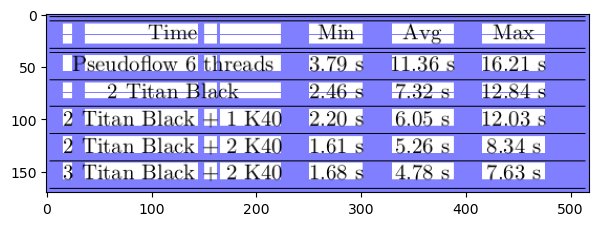

In [137]:
# VISUALIZE SPLIT PREDICTION
def vis_split(img, r, c, color='blue'):
    if color == 'red': theme = (255,0,0)
    elif color == 'green': theme = (0,255,0)
    else: theme = (0,0,255)
    r_im = r.reshape((-1,1)) * np.ones((r.shape[0],c.shape[0]))
    c_im = c.reshape((1,-1)) * np.ones((r.shape[0],c.shape[0]))
    bg = np.maximum(r_im, c_im)
    bg_img = np.concatenate(
        [bg[...,np.newaxis] * color for color in theme],
        axis=2
    )
    bg_img[np.all(bg_img == (0, 0, 0), axis=-1)] = (255,255,255)
    split_img = ((0.5 * img) + (0.5 * bg_img)).astype("uint8")
    split_img = np.minimum(split_img, img)
    view_imgs([split_img])

IDX = 10
img, label, img_name = dataset[IDX]
net.eval()
r,c = net(img.unsqueeze(0))
img, r, c = torch2numpy(img, r, c)
vis_split(img, r, c)

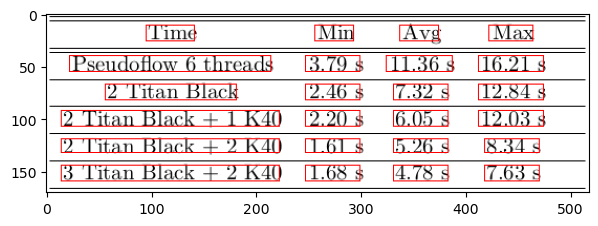

In [138]:
text_infos = chunk_labels[img_name]

img2 = img.copy()
for text, (l, t, r_, b) in text_infos:
    cv.rectangle(img2, (l, t), (r_, b), (255, 0, 0), 1)
view_imgs([img2])

In [139]:
# %%writefile merge/heuristics.py

def refine(x, threshold=2, adj_threshold=5):
    updated_x = x.copy()

    # Find indices of 1's in the array
    ones_indices = np.where(updated_x == 1)[0]

    # Iterate through the 1's indices and check for merging conditions
    i = 0
    while i < len(ones_indices):
        start_idx = ones_indices[i]
        end_idx = start_idx + threshold - 1

        # Check if there is another group of 1's within adj_threshold to the left or right
        if i + threshold < len(ones_indices) and ones_indices[i + threshold] - end_idx <= adj_threshold:
            end_idx = ones_indices[i + threshold]

            # Update all 1's in the range between the two groups to 1
            updated_x[start_idx:end_idx + 1] = 1

            # Move to the next unprocessed index
            i += threshold
        else:
            # Check if the merging condition is satisfied at the beginning of the array
            if start_idx - threshold >= 0 and start_idx - ones_indices[i - threshold] <= adj_threshold:
                start_idx = ones_indices[i - threshold]

                # Update all 1's in the range between the two groups to 1
                updated_x[start_idx:end_idx + 1] = 1
            else:
                updated_x[start_idx:end_idx + 1] = 0

            i += 1

    return updated_x

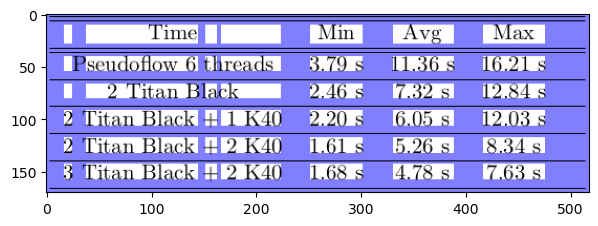

In [143]:
r_pred = refine(r)
c_pred = refine(c)
vis_split(img, r_pred, c_pred)

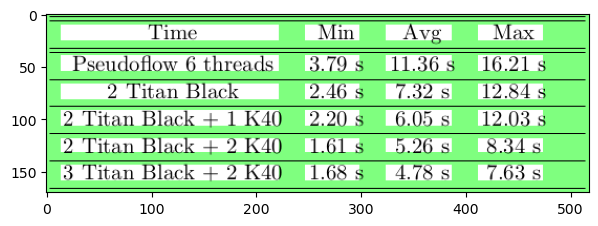

In [144]:
r_gt = np.array(merge_labels[img_name]['rows'])
c_gt = np.array(merge_labels[img_name]['columns'])
vis_split(img, r_gt, c_gt, 'green')